## Imports and Prep

In [1]:
####################
# IMPORT PACKAGES
####################

import numpy as np
import pandas as pd

import gensim
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import string

import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
####################
# READ IN USA MAP .shp file
# SAVE COORDINATE REFERENCE SYSTEM (this is needed for geopandas mapping later on)
####################
usa = gpd.read_file('./USA_shapefile/cb_2017_us_county_20m.shp')
crs = {'init': 'epsg:4326'}

In [3]:
####################
# LOAD TRAINED WORD2VEC MODEL - TRAINED ON 3-MILLION TOP WORDS FROM GOOLGE NEWS
####################
model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)


In [4]:
####################
# READ IN YOUR DATA.  WE HAVE INCLUDED A DATASET FOR DEMONSTRATION PURPOSES.  IF COLLECTING DATA 
#... THROUGH AN API, YOU CAN EITHER SAVE THE DATAFRAME OF TWEETS AS A CSV AND SPECIFY THE FILE 
#... PATH OR FEED THE OUTPUT DIRECTLY INTO THE CODE BELOW.

####################
florence_tweets = pd.read_csv('./hurricane_florence_tweets.csv')

florence_tweets.drop('Unnamed: 0',axis = 1, inplace = True)

florence_tweets.rename({'text':'tweet'}, axis=1, inplace=True)

english_stops = set(stopwords.words('english'))

tokenizer = RegexpTokenizer(r'\w+')

# IF USING ANY DATA BESIDES THE SET PROVIDED, ENSURE THAT YOUR LIST COMPREHENSION POINTS TO THE TWEET TEXT COLUMN
florence_tweet_tokens = [tokenizer.tokenize(tweet.lower()) for tweet in florence_tweets.tweet]

clean_florence_tweet_tokens = []
for tweet in florence_tweet_tokens:
    clean_tweet_tokens = []
    for word in tweet:
        if word not in english_stops and word not in ['@','rt', 'https', 'co', 'hurricaneflorence2018'] and '@' not in word:
            clean_tweet_tokens.append(word)
    clean_florence_tweet_tokens.append(clean_tweet_tokens)
###
# NOTE: YOUR OUTPUT AT THIS POINT MUST BE A LIST OF LISTS OF TOKENS. EACH INDIVIDUAL LIST WITHIN THE PARENT LIST
#... CORRESPONDS TO A TWEET (or sentence) FROM YOUR DATAFRAME
###

## Creating Demonstration Lat/Long Data

In [5]:
###
# THE FOLLOWING TWO CELLS ARE SPECIFICALLY FOR CREATING DEMONSTRATION LATITUDE AND LONGITUDE DATA.
#... UNCOMMENT THE CELLS IF YOUR DATASET DOES NOT ALREADY HAVE LATITUDE AND LONGITUDE
###

"""
florence_tweets['Latitude'] = 0

florence_tweets['Longitude'] = 0 

for x in range(len(florence_tweets['Latitude'])):
    florence_tweets['Latitude'][x] = format((np.random.random() + np.random.uniform(25, 39)), ".5f")

florence_tweets.Latitude = [float(i) for i in florence_tweets['Latitude']]
"""

'\nflorence_tweets[\'Latitude\'] = 0\n\nflorence_tweets[\'Longitude\'] = 0 \n\nfor x in range(len(florence_tweets[\'Latitude\'])):\n    florence_tweets[\'Latitude\'][x] = format((np.random.random() + np.random.uniform(25, 39)), ".5f")\n\nflorence_tweets.Latitude = [float(i) for i in florence_tweets[\'Latitude\']]\n'

In [6]:
"""
index = 0
for x in florence_tweets['Latitude']:
    if x > 37:
        florence_tweets['Longitude'][index] = format(-(77.5001 +np.random.random() + np.random.normal(0.0000, .8000)), ".5f")
    elif x > 35:
        florence_tweets['Longitude'][index] = format(-(77.6001 +np.random.random() + np.random.normal(0.0000, .8000)), ".5f")
    elif x > 32:
        florence_tweets['Longitude'][index] = format(-(81.0001 +np.random.random() + np.random.normal(0.0000, .80000)), ".5f")
    elif x > 30:
        florence_tweets['Longitude'][index] = format(-(82.5001 +np.random.random() + np.random.normal(0.0000, .65000)), ".5f")
    elif x > 28:
        florence_tweets['Longitude'][index] = format(-(81.5001 +np.random.random() + np.random.normal(0.0000, .4000)), ".5f")
    else:
        florence_tweets['Longitude'][index] = format(-(80.6001 +np.random.random() + np.random.normal(0.0000, .3000)), ".5f")
    index += 1

florence_tweets.Longitude = [float(i) for i in florence_tweets.Longitude]
"""


'\nindex = 0\nfor x in florence_tweets[\'Latitude\']:\n    if x > 37:\n        florence_tweets[\'Longitude\'][index] = format(-(77.5001 +np.random.random() + np.random.normal(0.0000, .8000)), ".5f")\n    elif x > 35:\n        florence_tweets[\'Longitude\'][index] = format(-(77.6001 +np.random.random() + np.random.normal(0.0000, .8000)), ".5f")\n    elif x > 32:\n        florence_tweets[\'Longitude\'][index] = format(-(81.0001 +np.random.random() + np.random.normal(0.0000, .80000)), ".5f")\n    elif x > 30:\n        florence_tweets[\'Longitude\'][index] = format(-(82.5001 +np.random.random() + np.random.normal(0.0000, .65000)), ".5f")\n    elif x > 28:\n        florence_tweets[\'Longitude\'][index] = format(-(81.5001 +np.random.random() + np.random.normal(0.0000, .4000)), ".5f")\n    else:\n        florence_tweets[\'Longitude\'][index] = format(-(80.6001 +np.random.random() + np.random.normal(0.0000, .3000)), ".5f")\n    index += 1\n\nflorence_tweets.Longitude = [float(i) for i in flore

## Turning Lat/Long Data into Point Objects for Mapping

In [7]:
####################
# THIS CELL IS SPECIFICALLY FOR CHANGING LATITUDE AND LONGITUDE INTO Point Objects FOR MAPPING.
#... UNCOMMENT THE CELLS IF YOU ARE USING REAL OR FAKE LONGITUDE AND LATITUDE
####################

###
# NOTE THAT Point IS A LIBRARY IMPORTED FROM Shapely. THIS IS NEEDED TO CREATE A GEODATAFRAME 
#... FOR USE WITH GEOPANDAS.  AFTER CREATING THE LIST OF POINTS, WE CAN DROP LATITUDE AND LONGITUDE.
###


# geometry = [Point(xy) for xy in zip(florence_tweets.Longitude, florence_tweets.Latitude)]
# florence_tweets.drop(['Latitude','Longitude'], axis = 1, inplace = True)

## Turning DataFrame into GeoDataFrame

In [ ]:
####################
# CREATE THE GEODATAFRAME, SPECIFYING AS PARAMETERS: THE ORIGINAL DATAFRAME, THE CRS SAVED ABOVE, AND
#... THE NEWLY CREATED LIST OF POINT OBJECTS. UNCOMMENT THE CODE ONLY IF YOU HAVE POINT OBJECTS IN YOUR
#... DATAFRAME FROM THE STEP ABOVE
####################

# florence_tweets = gpd.GeoDataFrame(florence_tweets, crs=crs, geometry = geometry)

In [8]:
####################
# HERE WE CREATE LISTS OF WORDS THAT WE THINK MAY INDICATE AN EMERGENCY, AND ANOTHER LIST OF WORDS THAT
#... WE THINK MAYBE LIKELY TO APPEAR IN NON-EMERGENCY TWEETS RELATED TO THE SAME NATURAL DISASTER. WE
#... WILL USE THESE LISTS OF WORDS TO CREATE VECTORS FOR Word2Vec COMPARISON IN THE NEXT FEW STEPS.
#... WE RECOMMEND USING SUBJECT MATTER EXPERTS TO DEVELOP APPROPRIATE WORD LISTS FOR THE GIVEN EVENT TYPE
#... (e.g. hurricane, wildfire, active military conflict)
####################

emergency_work = ['help', 'people', 'flood', 'leave', 'rescue', 'sos', 'come','debris', 'removal', 'junk', 'waste', 'property', 'tree', 'private', 'cubic', 'yard', 'creek',
                  'removal', 'roads', 'levees', 'unsafe', 'structures', 'water', 'floodplains',
                  'critical', 'evacuation', 'shelter', 'emergency', 'transport', 'access', 'safe', 'rescue',
                  'barricades', 'fire', 'generator', 'safety', 'hazard', 'need', 'lost', 'seen','missing', 'flooding', 'reach','trying']

# NOTE: WE REFER TO 'permanent_work' BECAUSE OF THAT IS HOW FEMA REFERS TO NON-EMERGENCY DAMAGE DURING DISASTERS
permanent_work = ['help', 'vegetation', 'mud', 'silt', 'bridge', 'waterways', 'facility', 'utilities', 'park', 'traffic', 'replacement', 'control',
                  'repairs', 'stabilization', 'remediation', 'surfaces', 'bases', 'shoulders', 'ditches', 'drainage',
                  'sidewalk', ' guardrails', 'signs', 'decking', 'pavement', 'channel' ,'alignment', 'irrigation', 'erosion',
                  'prevention', 'dams', 'reservoirs', 'basins ', 'canals', 'aqueducts', 'coastal', 'shoreline', 'pumping',
                  'building', 'mechanical', 'electrical', 'basement', 'painting', ' treatment',
                  'power', 'transmission', 'natural gas', 'sewage', 'permanent', 'restoration', 'communication', 'systems',
                  'inspection', 'assessment', 'beach', 'park',  'playground', 'pool', 'docks', 'golf', 'tennis',
                  'ball', 'port', 'harbor', 'fish', 'hatcheries', 'insurance', 'habitat', 'temporary']

## Vectorizing

In [9]:
####################
# CREATE THE EMERGENCY VECTOR
####################
emerg_vect = np.zeros((1,300))
counter=0
for word in emergency_work:
    if word not in model.vocab:
        continue
    else:
        temp = model.word_vec(word)
        emerg_vect=emerg_vect+temp
        counter +=1

emerg_vect=emerg_vect/counter
emerg_vect=np.squeeze(emerg_vect)
    #print(emerg_vect)

In [10]:
####################
# CREATE THE NON-EMERGENCY VECTOR
####################
permanent_vect = np.zeros((1,300))
counter=0
for word in permanent_work:
    if word not in model.vocab:
        continue
    else:
        temp = model.word_vec(word)
        permanent_vect=permanent_vect+temp
        counter +=1

permanent_vect=permanent_vect/counter
permanent_vect=np.squeeze(permanent_vect)
    #print(emerg_vect)

## Classification

In [11]:
####################
# THIS IS THE NLP STEP. THE LOOP WILL TURN EACH WORD IN YOUR LIST OF TOKENIZED TWEETS (or 
#... tokenized sentences) INTO A VECTOR, CLASSIFY THE WORD AS EMERGENCY OR NON-EMERGENCY USING COSINE
#... SIMILARITY, AND ASSIGN THE ENTIRE TWEET (or sentence) A VALUE BASED OFF OF THE BASELINE CLASSIFICATION
#... SCORE.
####################

target = [] # WE WILL FILL THIS WITH OUR CLASSIFICATIONS FOR EACH FULL TWEET
for tweet in clean_florence_tweet_tokens:
    
    counter=0
    for item in tweet:
        
        temp_vect = np.zeros((1, 300))
        if item not in model.vocab.keys(): # IF WORD NOT IN Word2Vec MODEL, IT IS NOT INCLUDED
            continue
        else:
            temp_vect = temp_vect + model.word_vec(item)
            counter += 1
    if counter==0:
        counter=1
    temp_vect = np.squeeze(temp_vect)/counter
        
        # THE BELOW STEP IS CALCULATING AND COMPARING THE COSINE SIMILARITIES. THE DOT PRODUCT IS CALCULATED
        #... FOR THE TWEET VECTOR AND THE EMERGENCY VECTOR AND FOR THE TWEET VECTOR AND THE NON-EMERGENCY
        #... VECTOR. AFTER CALCULATING THE DOT PRODUCT, WE DIVIDE BY THE ABS. VALUE OF THE TWO GIVEN VECTORS
        #... TO GET THE COSINE VALUE FOR THE ANGLE BETWEEN THE VECTORS. THE GREATER THE COSINE VALUE, THE CLOSER
        #... TWO VECTORS ARE TO ONE ANOTHER, AND TWEETS ARE ASSIGNED A CLASSIFICATION OF EMERGENCY OR NON-
        #... EMERGENCY ACCORDINGLY
    if np.dot(temp_vect, emerg_vect)/(np.linalg.norm(emerg_vect)*np.linalg.norm(temp_vect)) >= np.dot(temp_vect,permanent_vect)/(np.linalg.norm(permanent_vect)*np.linalg.norm(temp_vect)):
        target.append(1)
    else:
        target.append(0)
    

/home/ryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


In [12]:
# ADD CLASSIFICATIONS TO DATAFRAME OR GEODATAFRAME OF TWEETS
florence_tweets['target'] = target

Interpretation 1 is emergency and 0 is permanent

In [13]:
####################
# ADD CLASSIFICATIONS TO TWEET GEODATAFRAME
####################
florence_tweets['target'] = target

In [16]:
# UNCOMMENT TO SEE THE NUMBER OF TWEETS CLASSIFIED AS EMERGENCY AND NON-EMERGENCY
florence_tweets.target.value_counts()

0    9178
1     581
Name: target, dtype: int64

In [17]:
# UNCOMMENT TO SEE ONLY THE TWEETS THAT WERE FLAGGED
#florence_tweets[florence_tweets.target == 1]

,tweet,target
27,RT @SirBenjaminKing: #FantasyFootball sisters ...,1
109,what? it's wednesday and you still haven't see...,1
126,@ChoiceHotels can i trade my rewards points fo...,1
164,Does anyone know if there is a non GMO version...,1
217,@NC_Governor You better hope that you have ins...,1
221,"@MyrtleBeachGov My condolences to the family, ...",1
222,@fema What a joke. Denying claims without an i...,1
224,@POTUS @realDonaldTrump @NC_Governor @SenThomT...,1
243,"Within 18-hours, 270 airmen working together s...",1
255,RT @MedEconomics: Doctors who have lived throu...,1


## Mapping

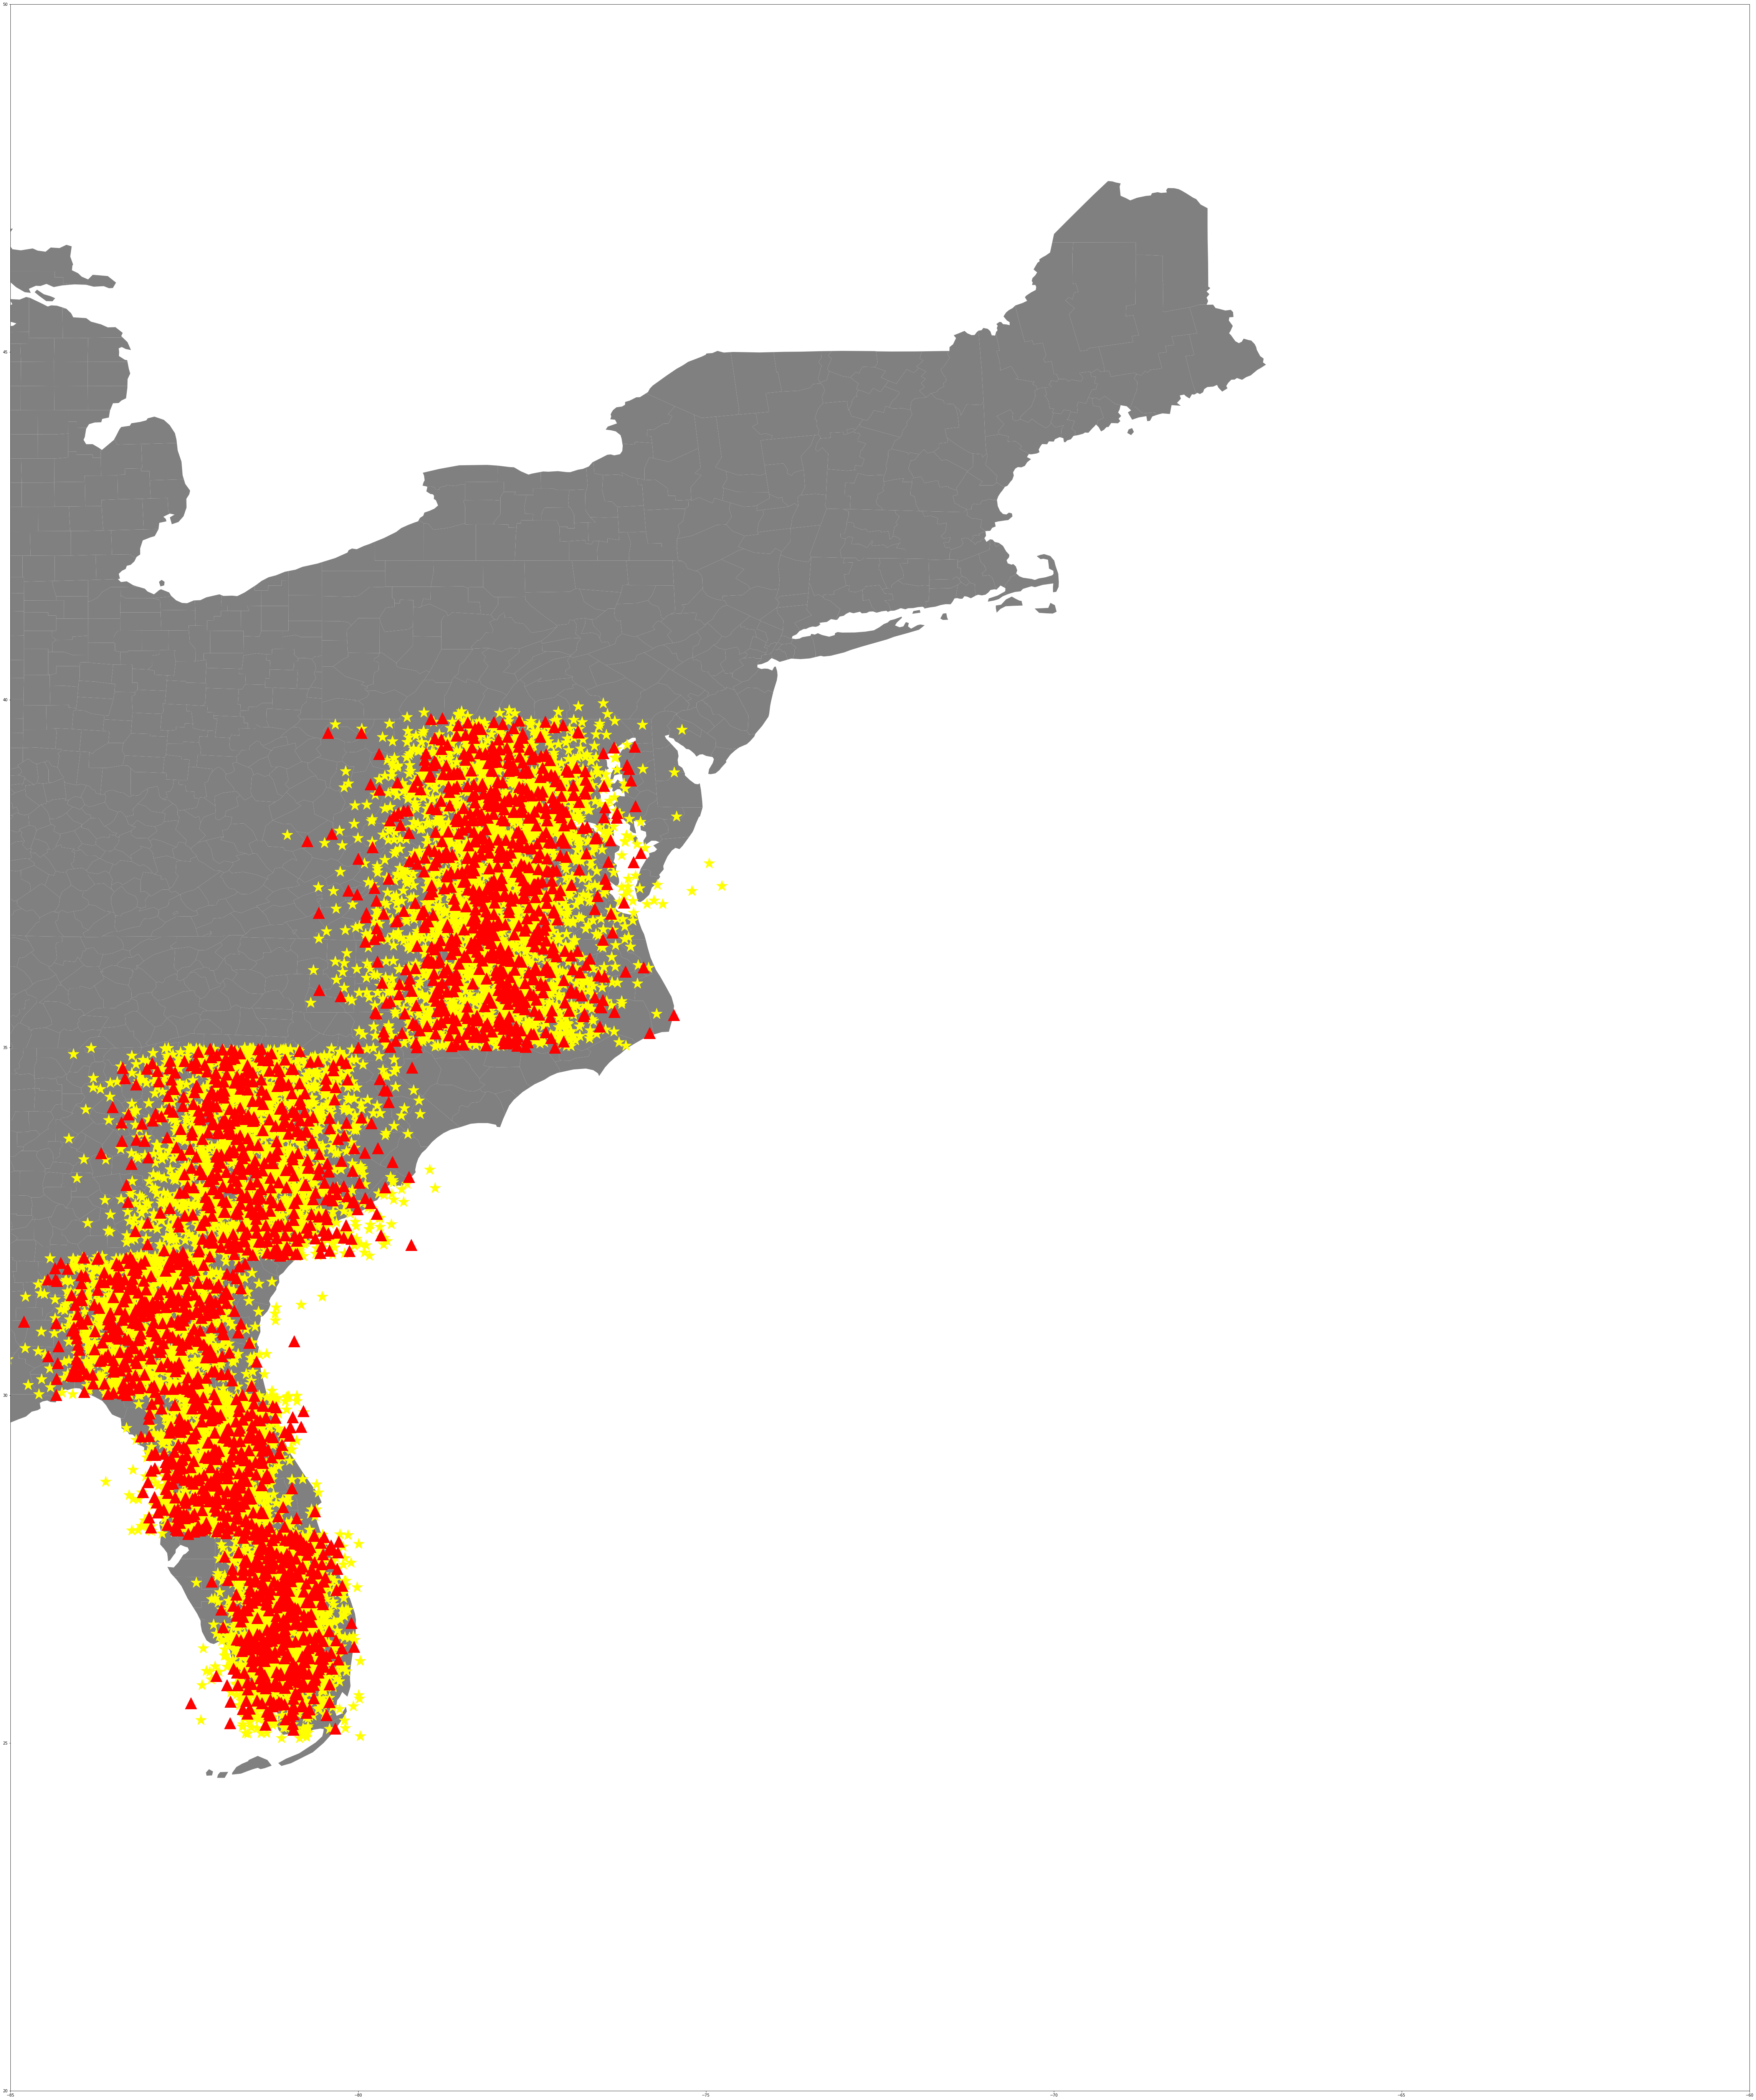

In [250]:
####################
# PLOTTING
#... NOTE: YOU CAN ONLY PLOT DATA ON A MAP IF YOU HAVE CREATED Point Objects FROM LAT/LONG DATA IN THE STEPS ABOVE
####################

"""
fig, ax = plt.subplots(figsize = (100,100))
usa.plot(ax = ax, color = 'gray') #USA .shp FILE READ IN ABOVE

# PLOTTING CLASSIFICATIONS SEPARATELY
florence_tweets[florence_tweets.target == 0].geometry.plot(marker='*', color='yellow', markersize=900, ax=ax, label = 'Tweet Loc')
florence_tweets[florence_tweets.target == 1].geometry.plot(marker='^', color='red', markersize=900, ax=ax, label = 'Tweet Loc')

# ADJUST MAP AREA DEPENDING ON TARGET AREA. xlim CORRESPONDS TO LONGITUDE RANGE, ylim CORRESPONDS TO
#... LATITUDE RANGE
plt.xlim(-85, -60)
plt.ylim(20,50)"""